## Models

Test out the following models:
K-Mode Clustering
XGBoost
Random Forest
Isomapping

GLM not necessary potentially?

In [10]:
# Necessary imports
#The foundation
#The models will be imported as needed
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Calling out the stored variable for our models from the Pre-Processing Notebook
from sklearn import datasets
%store -r df

In [43]:
df.head()

,ram_gb,ssd_gb,hdd_gb,graphic_card_gb,display_size,latest_price,os_bit_64,brand_APPLE,brand_ASUS,brand_Avita,...,ram_type_DDR5,ram_type_LPDDR3,ram_type_LPDDR4,ram_type_LPDDR4X,os_Mac,os_Windows,weight_Gaming,weight_ThinNlight,msoffice_Yes,Binarize_Warranty
0,4,0,1024,0,15.6,324.87,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,4,0,512,0,15.6,254.67,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4,128,0,0,15.6,259.87,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
3,4,128,0,0,15.6,279.37,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
4,4,256,0,0,15.6,324.87,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0


In [44]:
#Create the train and test set data that we'll be using - same steps from Pre-Processing
#X is all of the data that is not our target
#Y is our target latest price

X = df.drop('latest_price', axis = 1)
y = df[['latest_price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1234)

In [45]:
X_train

,ram_gb,ssd_gb,hdd_gb,graphic_card_gb,display_size,os_bit_64,brand_APPLE,brand_ASUS,brand_Avita,brand_DELL,...,ram_type_DDR5,ram_type_LPDDR3,ram_type_LPDDR4,ram_type_LPDDR4X,os_Mac,os_Windows,weight_Gaming,weight_ThinNlight,msoffice_Yes,Binarize_Warranty
679,8,0,512,8,15.60,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
96,4,256,0,0,15.60,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
709,8,512,0,0,14.00,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
218,8,0,512,4,15.60,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
518,16,256,0,4,15.60,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,8,256,1024,0,15.60,1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
53,8,256,0,0,14.00,1,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
294,8,512,0,4,15.60,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
723,8,0,1024,0,14.96,1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0


In [47]:
#Scale our X accordingly using MinMaxScaler
X_to_scale = ['ram_gb', 'ssd_gb', 'hdd_gb', 'graphic_card_gb']

#Initialize the MinMax Scaler
X_scaled = MinMaxScaler()

#Fit the X data for our numerical columns
X_scaled.fit(X_train[X_to_scale])

#Transform the X data for both the X_train and X_test
X_train_scaled = X_scaled.transform(X_train[X_to_scale])
X_test_scaled = X_scaled.transform(X_test[X_to_scale])

#Convert these back to dataframes so we can add them back in
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns = X_to_scale)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns = X_to_scale)

In [102]:
#Add back in the columns
#All the other columns
X_other_columns = X.columns.drop(X_to_scale)

#Join from scaled to not-scaled
X_train = X_train_scaled.join(X_train[X_other_columns])
X_test = X_test_scaled.join(X_test[X_other_columns])

#Make sure we have no crazy join issues, we should have shape [672,24] for train and [224,74] for test
print(X_train.shape)
print(X_test.shape)


(672, 74)
(224, 74)


In [15]:
#Start with K-Mode Clustering from: https://github.com/nicodv/kmodes
#Install using conda install -c conda-forge kmodes (on anaconda)
from kmodes import kmodes, kprototypes

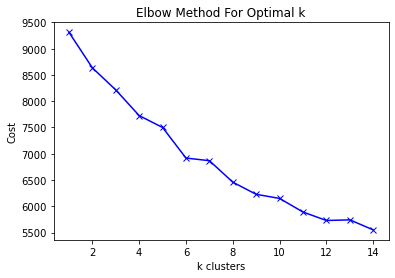

In [118]:
#We will initialize our model - documentation here: https://github.com/nicodv/kmodes/blob/master/kmodes/kprototypes.py
#We need to first see how many clusters would be ideal for our algorithm
#Also define the initialization method utilizing Cao's algorithm

cost =[]
K = range(1,15)
#categorical indices
categorical = list(range(5,74))
for num in list(K):
    kmodes = kprototypes.KPrototypes(n_clusters = num, init = 'Cao', n_init = 5);
    kmodes.fit_predict(X_train, categorical = categorical);
    cost.append(kmodes.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('k clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [119]:
#It seems that 11 clusters is the ideal grouping for our data
kmodes = kprototypes.KPrototypes(n_clusters = 11, init = 'Cao', n_init = 5);
kmodes.fit(X_train, categorical = categorical);
kmodes.predict(X_test, categorical = categorical);

In [124]:
kmodes.cost_
kmodes.cluster_centroids_

array([[1.92402973e-01, 1.47880539e-01, 1.87861272e-01, 1.87861272e-01,
        1.55213873e+01, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [114]:
kmodes.labels_

array([1, 4, 9, 1, 3, 5, 0, 9, 0, 4, 0, 8, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0,
       0, 8, 7, 0, 6, 2, 0, 4, 8, 3, 4, 4, 9, 0, 9, 0, 9, 3, 0, 0, 9, 5,
       0, 2, 0, 9, 4, 4, 0, 8, 4, 3, 4, 2, 4, 0, 0, 1, 7, 9, 4, 2, 6, 9,
       1, 0, 4, 8, 2, 0, 5, 7, 4, 7, 1, 4, 0, 6, 9, 4, 0, 9, 2, 0, 9, 9,
       0, 3, 5, 8, 5, 9, 2, 1, 8, 5, 0, 5, 3, 5, 0, 2, 9, 5, 2, 0, 6, 1,
       0, 0, 9, 5, 4, 0, 2, 6, 4, 9, 4, 9, 9, 6, 0, 4, 0, 4, 6, 2, 9, 0,
       4, 2, 0, 5, 5, 0, 9, 3, 3, 0, 3, 0, 9, 0, 4, 0, 2, 0, 4, 4, 4, 9,
       2, 0, 4, 0, 3, 0, 5, 6, 8, 9, 2, 7, 4, 5, 5, 0, 2, 5, 3, 0, 8, 0,
       0, 6, 0, 0, 5, 2, 8, 0, 6, 8, 4, 1, 9, 2, 0, 0, 5, 6, 9, 3, 9, 8,
       2, 0, 9, 0, 5, 0, 3, 2, 5, 4, 6, 0, 2, 0, 0, 0, 9, 2, 9, 8, 9, 9,
       7, 2, 8, 0, 9, 5, 0, 1, 9, 0, 0, 0, 3, 9, 6, 2, 9, 8, 6, 0, 9, 2,
       8, 8, 6, 0, 0, 7, 0, 0, 0, 4, 9, 5, 1, 0, 6, 0, 6, 0, 8, 6, 8, 2,
       5, 0, 0, 3, 5, 4, 9, 9, 4, 5, 0, 5, 2, 2, 3, 3, 8, 0, 0, 4, 0, 8,
       4, 9, 0, 3, 4, 4, 5, 0, 5, 0, 2, 9, 9, 5, 3,

## K Modes Thoughts

Although we were able to use K-Modes the inability to visualize or really understand the outputs of the clustering method makes it difficult to act upon. We're going to move on and try a different model.

-> potentially use price vs something else to interpret or pairwise at a time
https://openclassrooms.com/en/courses/5869986-perform-an-exploratory-data-analysis/6177861-analyze-the-results-of-a-k-means-clustering

